# Compare Gaia data products for internal consistency in flux

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
import re as regex
getobmt = lambda path: int(regex.search("(?<=OBMT_START_)[0-9]+",path).group(0))
import os

In [3]:
from astropy.io import fits

def fits_flux(filename):
    """
    Extract fluxes from a fits file of TrackObs
    Returns an array of acqTimes [OBMT] and fluxes [parts/cm^2/s]
    """
    # Open the file
    hdulist = fits.open(filename)
    
    # Create arrays for OBMT and fluxes
    acqTimes = np.empty(len(hdulist)-1, dtype=float)
    fluxes = np.empty(len(hdulist)-1, dtype=float)
    
    # Iterate over all the track-observations
    for ii in range(1,len(hdulist),1):
        head = hdulist[ii].header        
        
        maskpix = head["MASKPIX"]
        srcAL = head["SRC_AL"]
        srcAC = head["SRC_AC"]
        
        source = head["SOURCE"]
        # this bit could be put outside the loop if we are SURE that a fits file only has one source
        # I think it should, but this should be fairly quick anyhow
        if source in ["BAM-OBS","BAM-SIF"]:
            # 1 x 4 binning
            pixAL = 10e-4
            pixAC = 120e-4
            exptime = 4.5 * 0.9828 + 19
        elif source == "SM-SIF":
            # 2 x 2 binning
            pixAL = 20e-4
            pixAC = 60e-4
            exptime = 2.9 * 0.9828
            
        exparea = pixAL*pixAC*(srcAL*srcAC - maskpix)
        if exparea == 0:
            fluxes[ii-1] = 0
        else:
            fluxes[ii-1] = head["NAXIS2"]/exparea/exptime
        acqTimes[ii-1] = head["ACQTIME"]
    
    # Close the file
    hdulist.close()
    
    return acqTimes, fluxes

def PPE_flux(filename):
    """
    Extract fluxes from a PPE file.
    Returns an array of acqTimes [OBMT] and fluxes [parts/cm^2/s]
    """
    # get the times and nr of particles
    acqTimes = []
    fluxes = []
    
    ii = 0
    with open(filename,'r') as pf:
        for line in pf:
            # skip the first line
            if ii == 0:
                ii += 1
                continue
            line = line.split()
            acqTimes.append(int(line[0]))
            fluxes.append(float(line[4]))
    
    # sort everything by OBMT
    zipped = zip(acqTimes, fluxes)
    zipped = sorted(zipped, key=lambda t: t[0])
    
    # convert the nr. of particles to a flux
    fluxes = np.array([z[1] for z in zipped])
    
    exparea = 17.1 # cm^2 from Asier's TN
    exptime = 257.635 # s length of an ASD4 packet, from the TN
    
    fluxes = fluxes/exparea/exptime
    
    return np.array([z[0] for z in zipped]), fluxes

def get_row_fov(filename):
    """
    Extract rows and fovs of TrackObs in filename
    Returns an array of acqTimes [OBMT] and fluxes [parts/cm^2/s]
    """
    # Open the file
    hdulist = fits.open(filename)
    
    # Create arrays for OBMT and fluxes
    rows = np.zeros(len(hdulist)-1, dtype=int)
    fovs = np.zeros(len(hdulist)-1, dtype=int)
    
    # Iterate over all the track-observations
    for ii in range(1,len(hdulist),1):
        head = hdulist[ii].header        
        
        rows[ii-1] = head["CCD_ROW"]
        fovs[ii-1] = head["FOV"]
    
    # Close the file
    hdulist.close()
    
    return rows, fovs

In [4]:
# BAM-SIF and PPEs: Just load everything once

## BAM-SIF
tbams = []
fbams = []
prefix = "../bam_sif/output/"
for file in os.listdir(prefix):
    if "SIF1" in file:
        t,f = fits_flux(prefix+file)
        tbams+= list(t)
        fbams+= list(f)       
tbams = np.array(tbams)
fbams = np.array(fbams)

## SM-PPE
tp, fp = PPE_flux("../../datasets/PPE/ASD4_Counters_FOV1_ROW1.dat")

# Early June 2017

In [11]:
## SM-SIF
tsm, fsm = fits_flux("../sm_sif/output/SM1_2017-07.fits")


## BAM-OBS
tbamo = []
fbamo = []
for prefix in ["../bam/output/2017-07-03_cross_erosion/"]:
    # get the files and sort them by OBMT
    bamfiles = [prefix+file for file in os.listdir(prefix) if "OBS1" in file]
    bamfiles.sort(key=getobmt)
    # get the fluxes
    for file in bamfiles:
        t,f = fits_flux(file)
        tbamo+= list(t)
        fbamo+= list(f)    
tbamo = np.array(tbamo)
fbamo = np.array(fbamo)
#tbamo, fbamo = fits_flux("../bam/output/2017-07-EVT/BAM-OBS1_OBMT_START_117190342894417104.fits")


# out of curiosity, rebin bam obs
factor = 10

fbamo_r = fbamo[:len(fbamo)//factor * factor].reshape(len(fbamo)//10,10)
fbamo_r = np.average(fbamo_r, axis=1)

tbamo_r = tbamo[:len(fbamo)//factor * factor:10]

## BAM-OBS
tbamo2 = []
fbamo2 = []
for prefix in ["../bam/output/2017-07-03_cross_erosion/"]:
    # get the files and sort them by OBMT
    bamfiles = [prefix+file for file in os.listdir(prefix) if "OBS2" in file]
    bamfiles.sort(key=getobmt)
    # get the fluxes
    for file in bamfiles:
        t,f = fits_flux(file)
        tbamo2+= list(t)
        fbamo2+= list(f)    
tbamo2 = np.array(tbamo2)
fbamo2 = np.array(fbamo2)
#tbamo, fbamo = fits_flux("../bam/output/2017-07-EVT/BAM-OBS1_OBMT_START_117190342894417104.fits")


# out of curiosity, rebin bam obs
factor = 10

fbamo2_r = fbamo2[:len(fbamo2)//factor * factor].reshape(len(fbamo2)//10,10)
fbamo2_r = np.average(fbamo2_r, axis=1)

tbamo2_r = tbamo2[:len(fbamo2)//factor * factor:10]

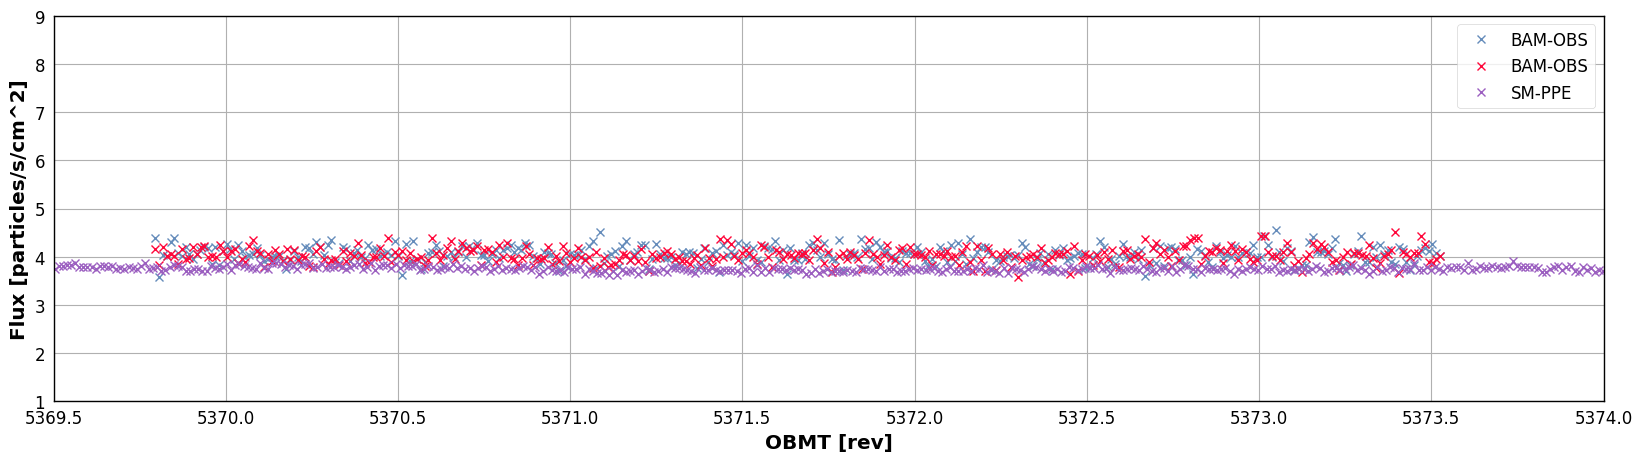

In [12]:
plt.plot((tbamo_r)/1e9/3600/6,fbamo_r,marker='x',label="BAM-OBS", linestyle='',color='xkcd:faded blue')
plt.plot((tbamo2_r)/1e9/3600/6,fbamo2_r,marker='x',label="BAM-OBS", linestyle='',color='xkcd:neon red')

#plt.plot((tbamo_r)/1e9/3600/6,fbamo_r,marker='x',label="BAM-OBS", linestyle='',color='xkcd:faded blue')

plt.plot((tp)/1e9/3600/6,fp,marker='x',label="SM-PPE", linestyle='', color='xkcd:amethyst')
#plt.plot((tsm)/1e9/3600/6,fsm,marker='x',label="SM-SIF", color='xkcd:tree green')
#plt.plot((tbams)/1e9/3600/6,fbams,marker='x',label="BAM-SIF",color='xkcd:neon red')


plt.legend(loc="best")

plt.xlim(5369.5,5374)  #Jul 2+3
plt.ylim(1,9)

plt.xlabel("OBMT [rev]")
plt.ylabel("Flux [particles/s/cm^2]")
plt.gcf().set_size_inches(20,5)

# Everything

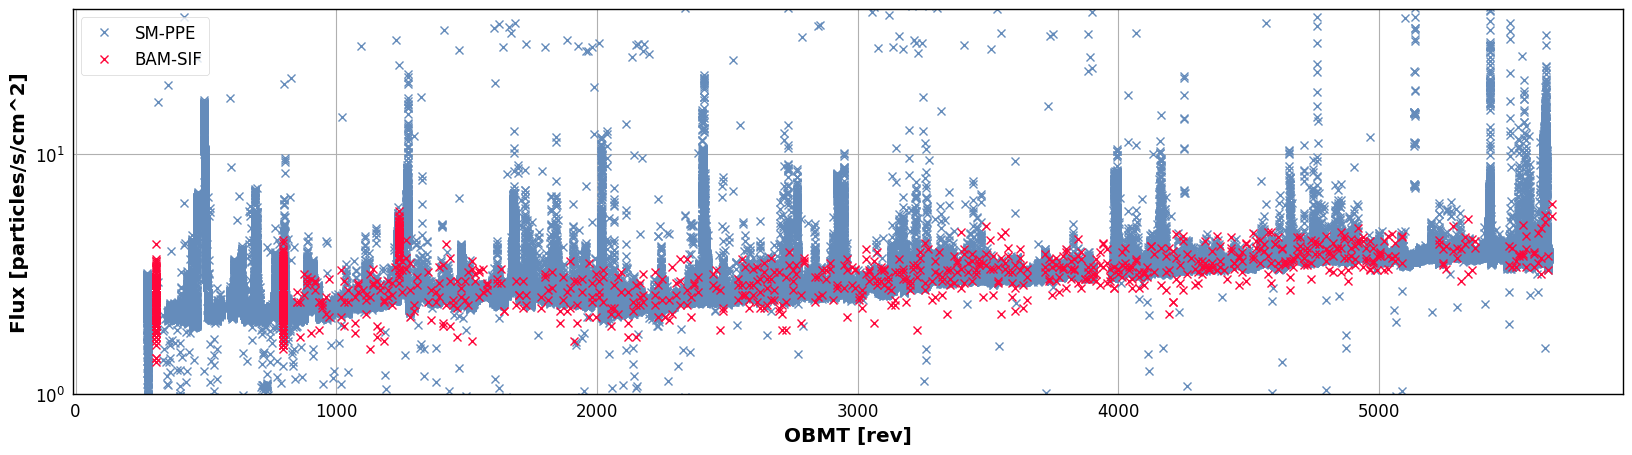

In [103]:
plt.plot((tp)/1e9/3600/6,fp,marker='x',label="SM-PPE", linestyle='', color='xkcd:faded blue')
plt.plot((tbams)/1e9/3600/6,fbams,marker='x',label="BAM-SIF", linestyle='',color='xkcd:neon red')


plt.legend(loc="best")

plt.yscale("log")
plt.ylim(1,40)

plt.xlabel("OBMT [rev]")
plt.ylabel("Flux [particles/s/cm^2]")
plt.gcf().set_size_inches(20,5)

# July 2017 Event

In [99]:
# July 2017 - particle event

## SM-SIF
tsm, fsm = fits_flux("../sm_sif/output/SM1_2017-07.fits")


## BAM-OBS
tbamo = []
fbamo = []
#for prefix in ["../bam/output/2017-07-02/", "../bam/output/2017-07-03/"]:
for prefix in ["../bam/output/2017-07-EVT/"]:
    # get the files and sort them by OBMT
    bamfiles = [prefix+file for file in os.listdir(prefix) if "OBS1" in file]
    bamfiles.sort(key=getobmt)
    # get the fluxes
    for file in bamfiles:
        t,f = fits_flux(file)
        tbamo+= list(t)
        fbamo+= list(f)    
tbamo = np.array(tbamo)
fbamo = np.array(fbamo)
#tbamo, fbamo = fits_flux("../bam/output/2017-07-EVT/BAM-OBS1_OBMT_START_117190342894417104.fits")


# out of curiosity, rebin bam obs
factor = 10

fbamo_r = fbamo[:len(fbamo)//factor * factor].reshape(len(fbamo)//10,10)
fbamo_r = np.average(fbamo_r, axis=1)

tbamo_r = tbamo[:len(fbamo)//factor * factor:10]

In [100]:
len(fbamo)

7367

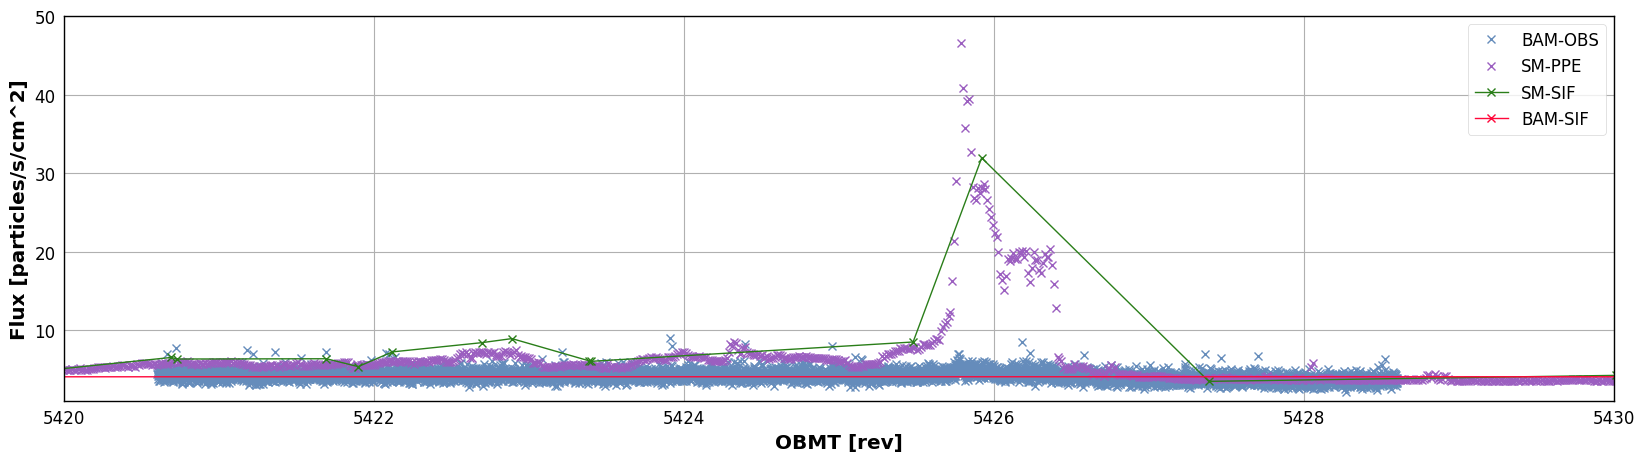

In [101]:
plt.plot((tbamo)/1e9/3600/6,fbamo,marker='x',label="BAM-OBS", linestyle='',color='xkcd:faded blue')
#plt.plot((tbamo_r)/1e9/3600/6,fbamo_r,marker='x',label="BAM-OBS", linestyle='',color='xkcd:faded blue')

plt.plot((tp)/1e9/3600/6,fp,marker='x',label="SM-PPE", linestyle='', color='xkcd:amethyst')
plt.plot((tsm)/1e9/3600/6,fsm,marker='x',label="SM-SIF", color='xkcd:tree green')
plt.plot((tbams)/1e9/3600/6,fbams,marker='x',label="BAM-SIF",color='xkcd:neon red')


plt.legend(loc="best")

#plt.yscale("log")
#plt.xlim(5364,5374)  #Jul 2+3
plt.xlim(5420,5430)  #July Event
#plt.xlim(5360,5500)  # All July
plt.ylim(1,50)

plt.xlabel("OBMT [rev]")
plt.ylabel("Flux [particles/s/cm^2]")
plt.gcf().set_size_inches(20,5)

In July Event: The peak flux should be somewhere in fits file Nr. 10 (not indexing 10!)

# Sept 2014 Event

In [123]:
## SM-SIF
tsm, fsm = fits_flux("../sm_sif/output/SM1_2014-09.fits")

## BAM-OBS
tbamo = []
fbamo = []
for prefix in ["../bam/output/2014-09-EVT/"]:
    # get the files and sort them by OBMT
    bamfiles = [prefix+file for file in os.listdir(prefix) if "OBS1" in file]
    bamfiles.sort(key=getobmt)
    # get the fluxes
    for file in bamfiles:
        t,f = fits_flux(file)
        tbamo+= list(t)
        fbamo+= list(f)      
tbamo = np.array(tbamo)
fbamo = np.array(fbamo)

# out of curiosity, rebin bam obs
factor = 10

fbamo_r = fbamo[:len(fbamo)//factor * factor].reshape(len(fbamo)//10,10)
fbamo_r = np.average(fbamo_r, axis=1)

tbamo_r = tbamo[:len(fbamo)//factor * factor:10]

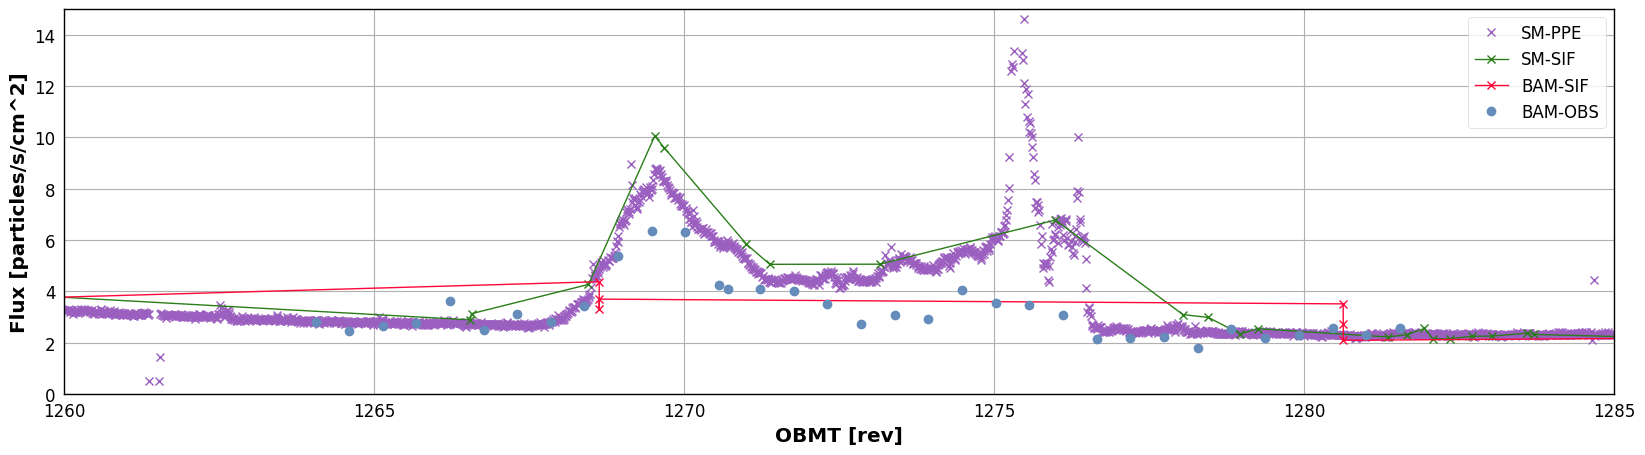

In [124]:
#plt.plot((tbamo)/1e9/3600/6,fbamo,marker='x',label="BAM-OBS", linestyle='',color='xkcd:faded blue')
#plt.plot((tbamo_r)/1e9/3600/6,fbamo_r,marker='x',label="BAM-OBS", linestyle='',color='xkcd:faded blue')

plt.plot((tp)/1e9/3600/6,fp,marker='x',label="SM-PPE", linestyle='', color='xkcd:amethyst')
plt.plot((tsm)/1e9/3600/6,fsm,marker='x',label="SM-SIF", color='xkcd:tree green')
plt.plot((tbams)/1e9/3600/6,fbams,marker='x',label="BAM-SIF",color='xkcd:neon red')

plt.plot((tbamo[::500])/1e9/3600/6,fbamo[::500],marker='o',label="BAM-OBS", linestyle='',color='xkcd:faded blue')


plt.legend(loc="upper right")

#plt.yscale("log")
plt.ylim(0,15)
plt.xlim(1260,1285)

plt.xlabel("OBMT [rev]")
plt.ylabel("Flux [particles/s/cm^2]")
plt.gcf().set_size_inches(20,5)

For BAM: The first peak is in file Files 10 and 11, the second in files 22 and 23

For SM: The peaks are in observation INDEX 22 and 23 as well as (at least a little) 27

# Sept 2017

In [17]:
## SM-SIF
tsm, fsm = fits_flux("../sm_sif/output/SM1_2017-09.fits")

## BAM-OBS
tbamo = []
fbamo = []
for prefix in ["../bam/output/2017-09-Precursor/", "../bam/output/2017-09-11/", "../bam/output/2017-09-Tail/"]:
    # get the files and sort them by OBMT
    bamfiles = [prefix+file for file in os.listdir(prefix) if "OBS1" in file]
    bamfiles.sort(key=getobmt)
    # get the fluxes
    for file in bamfiles:
        t,f = fits_flux(file)
        tbamo+= list(t)
        fbamo+= list(f)     
tbamo = np.array(tbamo)
fbamo = np.array(fbamo)

# out of curiosity, rebin bam obs
factor = 10

fbamo_r = fbamo[:len(fbamo)//factor * factor].reshape(len(fbamo)//10,10)
fbamo_r = np.average(fbamo_r, axis=1)

tbamo_r = tbamo[:len(fbamo)//factor * factor:10]

In [106]:
## SM-SIF
tsm, fsm = fits_flux("../sm_sif/output/SM1_2017-09.fits")

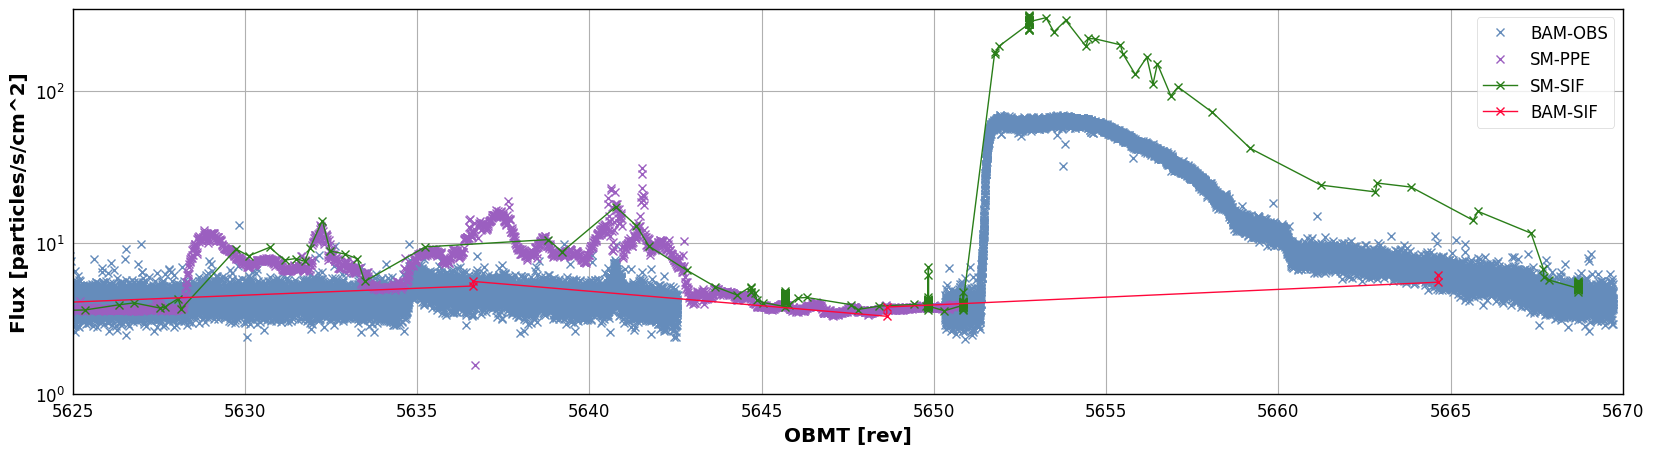

In [124]:
plt.plot((tbamo)/1e9/3600/6,fbamo,marker='x',label="BAM-OBS", linestyle='',color='xkcd:faded blue')
#plt.plot((tbamo_r)/1e9/3600/6,fbamo_r,marker='x',label="BAM-OBS", linestyle='',color='xkcd:faded blue')

plt.plot((tp)/1e9/3600/6,fp,marker='x',label="SM-PPE", linestyle='', color='xkcd:amethyst')
plt.plot((tsm)/1e9/3600/6,fsm,marker='x',label="SM-SIF", color='xkcd:tree green')
plt.plot((tbams)/1e9/3600/6,fbams,marker='x',label="BAM-SIF",color='xkcd:neon red')

plt.legend(loc="upper right")

plt.yscale("log")
plt.xlim(5625,5670) # Flare and precursor
#plt.xlim(5650,5670) # Flare
#plt.xlim(5627,5645) # precursor
plt.ylim(1,350)  # for flare
#plt.ylim(2,20)  # precursor


plt.xlabel("OBMT [rev]")
plt.ylabel("Flux [particles/s/cm^2]")
plt.gcf().set_size_inches(20,5)

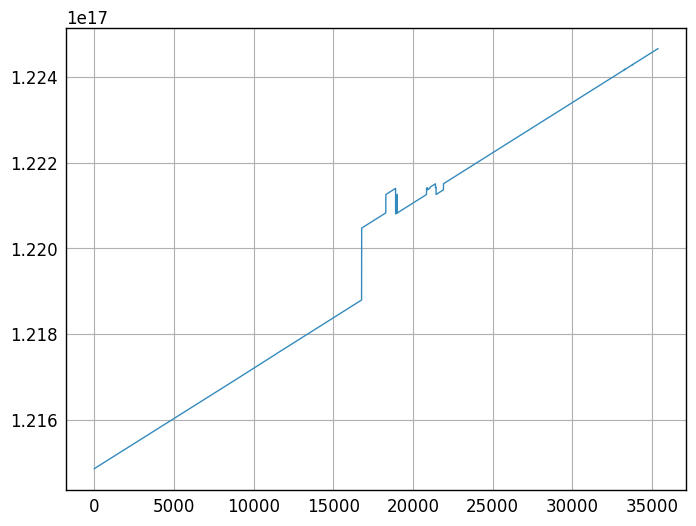

In [19]:
plt.plot(tbamo)
#plt.xlim(18000,19000)

In [130]:
## SM-SIF
tsm, fsm = fits_flux("../sm_sif/output/SM1_2017-08.fits")



In [131]:
tp3, fp3 = PPE_flux("../../datasets/PPE/ASD4_Counters_FOV2_ROW6.dat")

(5560, 5580)

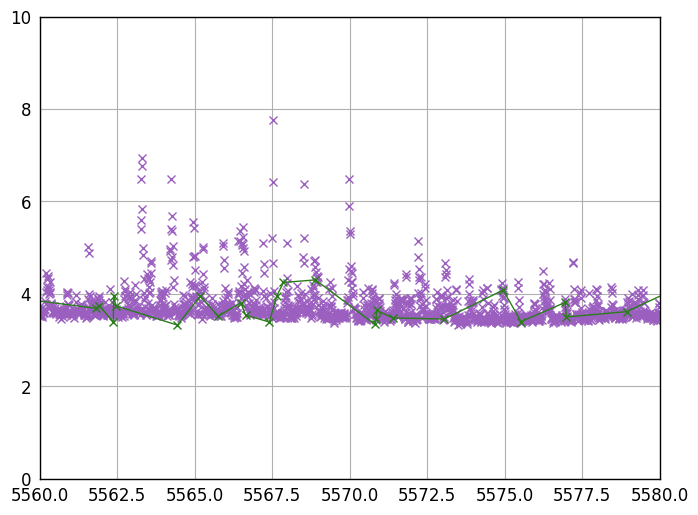

In [132]:
plt.plot((tp3)/1e9/3600/6,fp3,marker='x',label="SM-PPE", linestyle='', color='xkcd:amethyst')
plt.plot((tsm)/1e9/3600/6,fsm,marker='x',label="SM-SIF", color='xkcd:tree green')


plt.ylim(0,10)
#plt.xlim(5480,5620)
plt.xlim(5560,5580)

In [53]:
rows, fovs = get_row_fov("../sm_sif/output/SM1_2017-08.fits")

(290, 310)

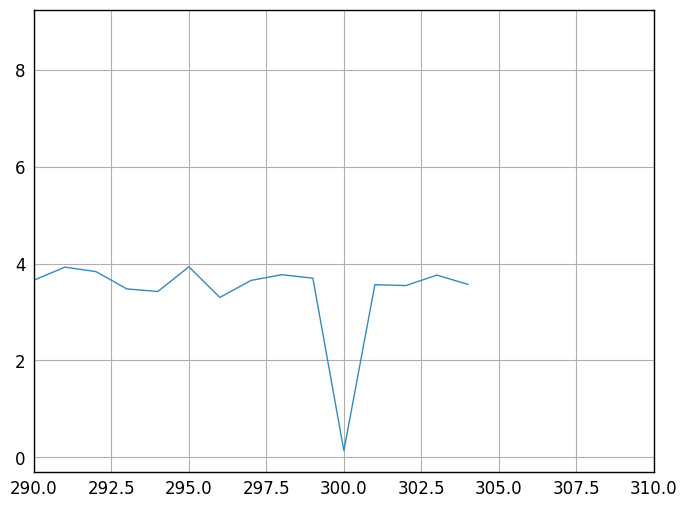

In [89]:
plt.plot(fsm)
plt.xlim(290,310)

In [90]:
int(tsm[300])

121099558999939104